## Import Packages

In [1]:
import re
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from time import sleep
from functools import reduce
from selenium import webdriver
# from selenium.webdriver.support.select import Select
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

## Scrape

In [2]:
link = 'https://www.dotabuff.com/heroes'
driver = webdriver.Chrome(r'C:\chromedriver')
driver.get(link)
urls = list(map(lambda x: x.get_attribute('href'),
                driver
                .find_elements_by_class_name('hero-grid')[0]
                .find_elements_by_xpath("./a")))

patch_ext = ['/counters?date=patch_7.19', '/counters?date=patch_7.20', 
             '/counters?date=patch_7.21', '/counters?date=patch_7.22',
             '/counters?date=patch_7.23', '/counters?date=patch_7.24']

# list(map(lambda x: x,patch_ext))

urls = reduce(lambda x, y: x+y, [list(map(lambda x: x+extension,urls)) for extension in patch_ext])

In [1]:
data_holder = []
for i,url in enumerate(urls):
#     print(f'Scraping: {url} , {i} out of {len(urls)} links.')
    driver.get(url)
    rows = driver.find_elements_by_class_name('sortable')[0].find_elements_by_xpath("./tbody/tr")
    df_tmp = pd.DataFrame(list(map(lambda x: 
                                   list(map(lambda y: 
                                            y.text,
                                            x.find_elements_by_xpath('./td'))),
                                   rows)))
    df_tmp[0] = [url]*len(df_tmp)
    data_holder.append(df_tmp)

## Clean

In [ ]:
from functools import reduce
df_final = reduce(lambda x,y:x.append(y),data_holder)
df_final = df_final.dropna()
df_final = df_final.reset_index(drop=True)
df_final.columns = ['url','to','advantage','winrate','number_matches']
df_final['patch'] = df_final['url'].apply(lambda x: 
                                          re.findall(r'patch_(.*)',x)[0])
df_final['from'] = df_final['url'].apply(lambda x: 
                                         re.findall(r'heroes/(.*)/counters',
                                                    x)[0])
df_final['from'] = df_final['from'].apply(lambda x: re.sub(r'-',' ',x))
df_final['to'] = df_final['to'].apply(lambda x: re.sub(r'-',' ',x))
df_final['to'] = df_final['to'].apply(lambda x: re.sub(r"[']",'',x))
df_final['to'] = df_final['to'].str.lower()
df_final['advantage'] = df_final['advantage'].apply(lambda x:
                                                    re.sub(r'%','',x))
df_final['advantage'] = df_final['advantage'].astype(float)
df_final['winrate'] = df_final['winrate'].apply(lambda x: re.sub(r'%','',x))
df_final['winrate'] = df_final['winrate'].astype(float)
df_final['number_matches'] = df_final['number_matches'].apply(lambda x:
                                                              re.sub(r',','',
                                                                     x))
df_final['number_matches'] = df_final['number_matches'].astype(float)
df_final.head()

## Check

In [21]:
print(all([x==y for x,y in zip(sorted(df_final['to'].unique()),
                               sorted(df_final['from'].unique()))]))
df_final['pairing'] = list(map(lambda x: 
                               sorted(list(x))[0]+'-'+sorted(list(x))[1],
                               list(zip(df_final['from'], df_final['to']))))
matchups = df_final['pairing'].unique()
len(matchups)

True


7021

## Drop Compliment Edges

In [18]:
idx = df_final.groupby('pairing')['winrate'].transform(max) == df_final['winrate']
df_pairs = df_final[idx]

## Delete 50/50 Duplicate Edges

In [19]:
df_tmp = pd.DataFrame(df_pairs['pairing'].value_counts())
df_pairs = df_pairs.drop([df_pairs[df_pairs['pairing']==pair].index[-1] 
                          for pair in df_tmp[df_tmp['pairing']>1].index], 
                         axis=0)
df_pairs = df_pairs.reset_index(drop=True)
print(df_pairs.shape)
df_pairs.head()

(7021, 8)


,url,to,advantage,winrate,number_matches,patch,from,pairing
0,https://www.dotabuff.com/heroes/abaddon/counte...,broodmother,3.97,50.58,6896.0,7.24,abaddon,abaddon-broodmother
1,https://www.dotabuff.com/heroes/abaddon/counte...,outworld devourer,3.84,51.86,35464.0,7.24,abaddon,abaddon-outworld devourer
2,https://www.dotabuff.com/heroes/abaddon/counte...,pangolier,2.12,51.62,32114.0,7.24,abaddon,abaddon-pangolier
3,https://www.dotabuff.com/heroes/abaddon/counte...,lycan,2.05,54.74,3800.0,7.24,abaddon,abaddon-lycan
4,https://www.dotabuff.com/heroes/abaddon/counte...,lina,1.89,54.41,48743.0,7.24,abaddon,abaddon-lina


In [20]:
patch = df_pairs['patch'].unique()[0]
df_pairs.to_csv(f'Dota_Data_{patch}.csv')

## Concatenate

In [106]:
data_patches = ['Dota_Data_719.csv','Dota_Data_720.csv','Dota_Data_721.csv',
                'Dota_Data_722.csv','Dota_Data_723.csv','Dota_Data_724.csv']

df = reduce(lambda x,y: x.append(y),
            [pd.read_csv(patch_data) for patch_data in data_patches])
df = df[['from','to','advantage','winrate','number_matches','patch','pairing','url']]
df.columns = ['from','to','disadvantage','winrate_from','number_matches','patch','pairing','url']
df['winrate_to'] = [100]*len(df)-df['winrate_from']
df = df[['from','to','disadvantage','winrate_from','winrate_to','number_matches','patch','pairing','url']]
df.head()

,from,to,disadvantage,winrate_from,winrate_to,number_matches,patch,pairing,url
0,abaddon,slark,3.53,50.52,49.48,135700.0,7.19,abaddon-slark,https://www.dotabuff.com/heroes/abaddon/counte...
1,abaddon,broodmother,2.43,50.85,49.15,32125.0,7.19,abaddon-broodmother,https://www.dotabuff.com/heroes/abaddon/counte...
2,abaddon,enchantress,2.42,53.27,46.73,52719.0,7.19,abaddon-enchantress,https://www.dotabuff.com/heroes/abaddon/counte...
3,abaddon,outworld devourer,2.31,57.58,42.42,39110.0,7.19,abaddon-outworld devourer,https://www.dotabuff.com/heroes/abaddon/counte...
4,abaddon,alchemist,1.80,50.58,49.42,78021.0,7.19,abaddon-alchemist,https://www.dotabuff.com/heroes/abaddon/counte...


In [107]:
df.to_csv('Dota_Data_All_Patches.csv')

## Prelim Analysis

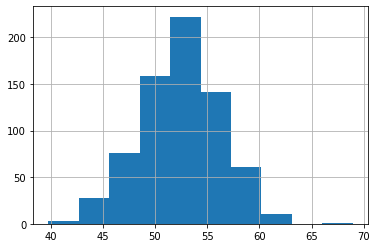

In [125]:
df[df['from']=='clockwerk']['winrate_from'].append(df[df['to']=='clockwerk']['winrate_to']).hist()

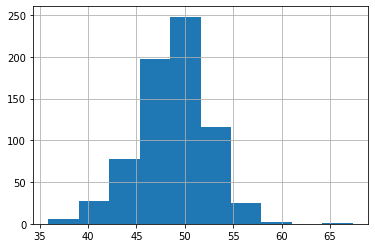

In [126]:
df[df['from']=='pangolier']['winrate_from'].append(df[df['to']=='pangolier']['winrate_to']).hist()

In [131]:
import matplotlib.pyplot as plt
df[df['pairing']=='clockwerk-nyx assassin']

,from,to,disadvantage,winrate_from,winrate_to,number_matches,patch,pairing,url
1255,clockwerk,nyx assassin,-0.18,50.86,49.14,99820.0,7.19,clockwerk-nyx assassin,https://www.dotabuff.com/heroes/clockwerk/coun...
1147,clockwerk,nyx assassin,-0.24,52.27,47.73,28033.0,7.20,clockwerk-nyx assassin,https://www.dotabuff.com/heroes/clockwerk/coun...
1161,clockwerk,nyx assassin,-0.06,50.43,49.57,77344.0,7.21,clockwerk-nyx assassin,https://www.dotabuff.com/heroes/clockwerk/coun...
1227,clockwerk,nyx assassin,0.37,54.00,46.00,92908.0,7.22,clockwerk-nyx assassin,https://www.dotabuff.com/heroes/clockwerk/coun...
1111,clockwerk,nyx assassin,0.13,54.28,45.72,27084.0,7.23,clockwerk-nyx assassin,https://www.dotabuff.com/heroes/clockwerk/coun...
1068,clockwerk,nyx assassin,0.42,51.70,48.30,36114.0,7.24,clockwerk-nyx assassin,https://www.dotabuff.com/heroes/clockwerk/coun...


## Rankings Scrape

In [2]:
driver = webdriver.Chrome(r'C:\chromedriver')


urls = ['https://www.dotabuff.com/heroes/winning?date=patch_7.19',
        'https://www.dotabuff.com/heroes/winning?date=patch_7.20', 
        'https://www.dotabuff.com/heroes/winning?date=patch_7.21', 
        'https://www.dotabuff.com/heroes/winning?date=patch_7.22',
        'https://www.dotabuff.com/heroes/winning?date=patch_7.23', 
        'https://www.dotabuff.com/heroes/winning?date=patch_7.24']

data_holder = []
for i, url in enumerate(urls):
    print(f'Scraping: {url} , {i} out of {len(urls)} links.')
    driver.get(url)
    rows = driver.find_elements_by_class_name('sortable')[0].find_elements_by_xpath("./tbody/tr")
    df_tmp = pd.DataFrame(list(map(lambda x: 
                                   list(map(lambda y: 
                                            y.text,
                                            x.find_elements_by_xpath('./td'))),
                                   rows)))
    df_tmp[0] = [url]*len(df_tmp)
    data_holder.append(df_tmp)

Scraping: https://www.dotabuff.com/heroes/winning?date=patch_7.19 , 0 out of 6 links.
Scraping: https://www.dotabuff.com/heroes/winning?date=patch_7.20 , 1 out of 6 links.
Scraping: https://www.dotabuff.com/heroes/winning?date=patch_7.21 , 2 out of 6 links.
Scraping: https://www.dotabuff.com/heroes/winning?date=patch_7.22 , 3 out of 6 links.
Scraping: https://www.dotabuff.com/heroes/winning?date=patch_7.23 , 4 out of 6 links.
Scraping: https://www.dotabuff.com/heroes/winning?date=patch_7.24 , 5 out of 6 links.


In [19]:
def change_df(df):
    
    df.columns=['url','hero','winrate','pickrate','kda_ratio']
    
    df['hero'] = df['hero'].str.lower()
    df['hero'] = df['hero'].str.replace("'",'')
    df['hero'] = df['hero'].str.replace("-",'')
    
    df['winrate'] = df['winrate'].str.replace('%','')
    df['winrate'] = df['winrate'].astype(float)
    
    df['pickrate'] = df['pickrate'].str.replace('%','')
    df['pickrate'] = df['pickrate'].astype(float)
    
    return df

data_tmp = list(map(lambda x: change_df(x), data_holder))

In [22]:
def patch(x):
    x[1]['patch'] = [x[0]]*len(x[1])
    return x[1]

In [26]:
data_tmp = list(map(lambda x: patch(x), zip(['7.19','7.20','7.21','7.22','7.23','7.24'], data_tmp)))

In [28]:
df_final = reduce(lambda x, y: x.append(y), data_tmp)

In [30]:
df_final.to_csv('winrates.csv')